In [1]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn as nn

In [2]:
batch_size = 32
input_dim = 5
output_dim = 1
epochs = 15

In [3]:
data_arr= np.load('res.npy', allow_pickle=True)

In [4]:
data_df = pd.DataFrame(data_arr, columns=['number', 'steps', 'q1', 'median', 'q2', 'maximum', 'standard steps', 'logistic steps'], dtype=np.float64)
len(data_df)

1000000

In [5]:
data_df.head()

,number,steps,q1,median,q2,maximum,standard steps,logistic steps
0,3.551399e+20,433.0,1.780000e+03,2.522568e+10,7.847522e+12,3.196259e+21,1.172840,0.763658
1,3.344763e+20,425.0,2.860621e+08,1.186557e+11,4.374864e+13,3.010286e+21,1.008230,0.732674
2,1.823451e+20,339.0,1.870040e+06,7.781301e+07,5.308293e+10,1.641106e+21,-0.761317,0.318360
3,4.116974e+20,198.0,6.376250e+03,3.784900e+06,1.050230e+14,3.705276e+21,-3.662551,0.025025
4,4.140167e+20,304.0,3.140990e+05,8.947985e+07,9.912957e+09,3.726150e+21,-1.481481,0.185204


In [6]:
class Cus_Dataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.x = torch.tensor(self.data.iloc[:, [0,2,3,4,5]].values)
        #temp = list(map(lambda x: '{0:069b}'.format(int(x)), numbers))
        #x = list(map(lambda x: [int(char) for char in x], temp))
        #self.x = torch.tensor(x, dtype=torch.float64)

        self.y = torch.tensor(self.data['steps'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        return self.x[index], self.y[index]

In [7]:
data = Cus_Dataset(data_df)

In [8]:
gen = torch.Generator()
gen.manual_seed(0)
train_df, val_df, test_df = random_split(data, [0.75, 0.2, 0.05], generator=gen)

In [9]:
train_data_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_df, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_df, batch_size=batch_size, shuffle=True)

In [10]:
print(f"Train dataset length: {batch_size * len(train_data_loader)}")
print(f"Validation dataset length: {batch_size * len(val_data_loader)}")
print(f"Test dataset length: {batch_size * len(test_data_loader)}")

Train dataset length: 750016
Validation dataset length: 200000
Test dataset length: 50016


In [ ]:
#for idx, batch in enumerate(train_data_loader):
#    x, y = batch
#    batch_no = idx + 1
#    print(f"Batch number: {batch_no}, Batch size: {len(x)} \nnumber: {x} \ntarget: {y}")
#    break
    

In [12]:
#import math
#lst_log = list(map(lambda x: math.log(x), data_arr[:,0]))
#c=torch.tensor(lst_log, dtype=torch.float64)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
#Model Architecture
class Model(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 2),
            nn.ReLU(),
            nn.Linear(2, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [15]:
model = Model(input_dim, output_dim)
model = model.to(device)

In [16]:
model = model.to(torch.float64)

In [17]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
## Training loop
loss_per_epoch = []

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    loss_list = []

    for idx, batch in enumerate(train_data_loader):
        x, target = batch
        batch_no = idx + 1
        
        #x = x.reshape(-1,1)
        target = target.reshape(-1,1)
        x = x.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        y = model(x)
        loss = loss_fn(y, target)
        
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if batch_no%4000 == 0:
            print(f"   Batch: {batch_no}, Loss: {loss.item():.4f}")

    avg_loss = sum(loss_list)/len(loss_list)
    print(f"   Average loss: {avg_loss:.4f}\n")
    loss_per_epoch.append(avg_loss)
    #sqrt_mean_loss.append(np.sqrt(avg_loss))

#print(f"Squared Mean Loss List: {sqrt_mean_loss}")

Epoch: 1/15
   Batch: 4000, Loss: 67.1162
   Batch: 8000, Loss: 80.6349
   Batch: 12000, Loss: 60.9038
   Batch: 16000, Loss: 56.8683
   Batch: 20000, Loss: 76.5352
   Average loss: 75.7250

Epoch: 2/15
   Batch: 4000, Loss: 86.0895
   Batch: 8000, Loss: 64.6251
   Batch: 12000, Loss: 79.3215
   Batch: 16000, Loss: 76.5393
   Batch: 20000, Loss: 78.7486
   Average loss: 73.9996

Epoch: 3/15
   Batch: 4000, Loss: 67.4972
   Batch: 8000, Loss: 67.3027
   Batch: 12000, Loss: 80.0627
   Batch: 16000, Loss: 71.5764
   Batch: 20000, Loss: 64.1138
   Average loss: 73.6960

Epoch: 4/15
   Batch: 4000, Loss: 56.7309
   Batch: 8000, Loss: 71.8763
   Batch: 12000, Loss: 78.8486
   Batch: 16000, Loss: 74.4124
   Batch: 20000, Loss: 74.7500
   Average loss: 73.6668

Epoch: 5/15
   Batch: 4000, Loss: 78.4052
   Batch: 8000, Loss: 53.1320
   Batch: 12000, Loss: 71.9369
   Batch: 16000, Loss: 82.6258
   Batch: 20000, Loss: 62.3750
   Average loss: 73.6623

Epoch: 6/15
   Batch: 4000, Loss: 65.2828
   

In [21]:
#sqrt_mean_loss = sqrt_mean_loss[1:]

<AxesSubplot:>

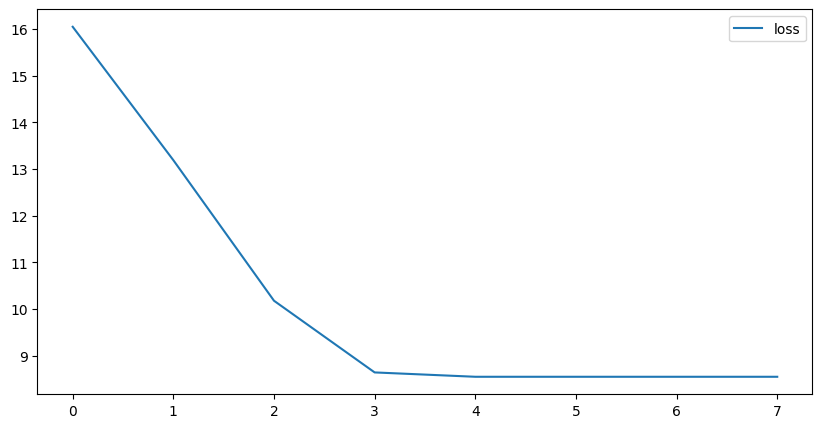

In [22]:
pd.DataFrame(data={"loss":loss_per_epoch}).plot(figsize=(10,5))

In [23]:
# validation

val_loss = 0

with torch.no_grad():
    for idx, batch in enumerate(val_data_loader):
        x, target = batch
        batch_no = idx + 1
        
        #x = x.reshape(-1,1)
        target = target.reshape(-1,1)
        x = x.to(device)
        target = target.to(device)
                
        y = model(x)
        loss = loss_fn(y, target)
        
        val_loss += loss.item()

val_mean_loss = val_loss/len(val_data_loader)
print(f"Validation loss: {val_mean_loss:.4f}")
#print(f"Square root validation loss: {np.sqrt(val_mean_loss):.4f}")

Validation loss: 73.0167
Square root validation loss: 8.5450


In [24]:
target.reshape(-1)

tensor([263., 407., 445., 326., 371., 483., 482., 322.], dtype=torch.float64)

In [25]:
y.reshape(-1)

tensor([376.5913, 376.5913, 376.5913, 376.5913, 376.5913, 376.5913, 376.5913,
        376.5913], dtype=torch.float64)

In [26]:
print(target.mean())
print(target.median())

tensor(387.3750, dtype=torch.float64)
tensor(371., dtype=torch.float64)


In [ ]:
print(f"Loss for this batch: {loss(y, target)}")

In [27]:
mean = 0
median = 0
for idx, batch in enumerate(train_data_loader):
    x, y = batch
    mean = mean + y.mean()
    median = median + y.median()
print(f"Mean: {mean/len(train_data_loader)}")
print(f"Median: {median/len(train_data_loader)}")

KeyboardInterrupt: 